# Closeness Centrality
_Closeness Centrality_ is a way of detecting nodes that are able to spread information very efficiently through a graph.

The _Closeness Centrality_ of a node measures its average distance to all other nodes.
Nodes with a high closeness score have the shortest distances to all other nodes.

First we'll import the Neo4j driver and Pandas libraries:


In [1]:
from neo4j import GraphDatabase
import pandas as pd
import os

Next let's create an instance of the Neo4j driver which we'll use to execute our queries.


In [2]:
host = os.environ.get("NEO4J_HOST", "bolt://localhost") 
user = os.environ.get("NEO4J_USER", "neo4j")
password = os.environ.get("NEO4J_PASSWORD", "neo")
driver = GraphDatabase.driver(host, auth=(user, password))

Now let's create a sample graph that we'll run the algorithm against.


In [3]:
create_graph_query = '''
MERGE (a:Node{id:"A"})
MERGE (b:Node{id:"B"})
MERGE (c:Node{id:"C"})
MERGE (d:Node{id:"D"})
MERGE (e:Node{id:"E"})

MERGE (a)-[:LINK]->(b)
MERGE (b)-[:LINK]->(a)
MERGE (b)-[:LINK]->(c)
MERGE (c)-[:LINK]->(b)
MERGE (c)-[:LINK]->(d)
MERGE (d)-[:LINK]->(c)
MERGE (d)-[:LINK]->(e)
MERGE (e)-[:LINK]->(d);
'''

with driver.session() as session:
    result = session.write_transaction(lambda tx: tx.run(create_graph_query))
    print("Stats: " + str(result.consume().metadata.get("stats", {})))

Stats: {'labels-added': 5, 'relationships-created': 8, 'nodes-created': 5, 'properties-set': 5}


Finally we can run the algorithm by executing the following query:


In [4]:
streaming_query = """
CALL gds.alpha.closeness.stream({
    nodeProjection:'Node', 
    relationshipProjection:'LINK'})
YIELD nodeId, centrality

MATCH (n:Node) WHERE id(n) = nodeId

RETURN n.id AS node, centrality
ORDER BY centrality DESC
limit 20;
"""

with driver.session() as session:
    result = session.run(streaming_query)      
    df = pd.DataFrame([dict(r) for r in result])

df

,node,centrality
0,C,0.666667
1,B,0.571429
2,D,0.571429
3,E,0.400000
4,A,0.400000


"C" is the best connected node in this graph although "B" and "D" aren't far behind.
"A" and "E" don't have close ties to many other nodes so their scores are lower.
A score of 1 would indicate that a node has a direct connection to all other nodes.

We can also call a version of the algorithm that will store the result as a property on a
node. This is useful if we want to run future queries that use the result.

In [5]:
write_query = """
CALL gds.alpha.closeness.write({
    nodeProjection:'Node', 
    relationshipProjection:'LINK', 
    writeProperty:'centrality'}) 
YIELD nodes,createMillis, computeMillis, writeMillis;
"""

with driver.session() as session:
    session.write_transaction(lambda tx: tx.run(write_query))

## Graph Visualisation

Sometimes a picture can tell more than a table of results and this is often the case with graph algorithms. 
Let's see how to create a graph visualization using neovis.js.

First we'll create a div into which we will generate the visualisation.

In [7]:
%%html
<style type="text/css">                
.output_wrapper, .output {
    height:auto !important;
    max-height:600px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}

#viz {
    width: 300px;
    height: 350px;
    font: 22pt arial;
}
</style>  
<div id="viz"></div>

Next we need to define the query that the visualization will be generated from, along with config 
that describes which properties will be used for node size, node colour, and relationship width. 

We'll then define a JavaScript variable that contains all our parameters.

In [8]:
from IPython.core.display import Javascript
import json
from scripts.algo import viz_config, render_image

config = viz_config("Closeness Centrality")
query = config["query"]
labels_json = config["labels_json"]
relationships_json = config["relationships_json"]

json_graph = {
    "query": query,
    "labels": labels_json,
    "relationships": relationships_json,
    "host": host,
    "user": user,
    "password": password
}

Javascript("""window.jsonGraph={};""".format(json.dumps(json_graph)))

<IPython.core.display.Javascript object>

Now we're ready to call neovis.js and generate our graph visualisation. 
The following code will create an interactive graph into the div defined above.
It will also extract an image representation of the graph and display that in the cell below.

In [8]:
%%javascript
var output_area = this;
requirejs(['neovis.js'], function(NeoVis){    
    var config = {
      container_id: "viz",
      server_url: window.jsonGraph.host,
      server_user: window.jsonGraph.user,
      server_password: window.jsonGraph.password,
      labels: window.jsonGraph.labels,
      relationships: window.jsonGraph.relationships,
      initial_cypher: window.jsonGraph.query
    };
        
    let viz = new NeoVis.default(config);
    viz.render();
    
    viz.onVisualizationRendered(function(ctx) {
      let imageSrc = ctx.canvas.toDataURL();
      let kernel = IPython.notebook.kernel;
      let command = "image_src = '" + imageSrc + "'";
      kernel.execute(command);
      
      var cell_element = output_area.element.parents('.cell');
      var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
      var cell = Jupyter.notebook.get_cell(cell_idx+1);
      cell.set_text("render_image(image_src)")
      cell.execute();
    });
});

<IPython.core.display.Javascript object>


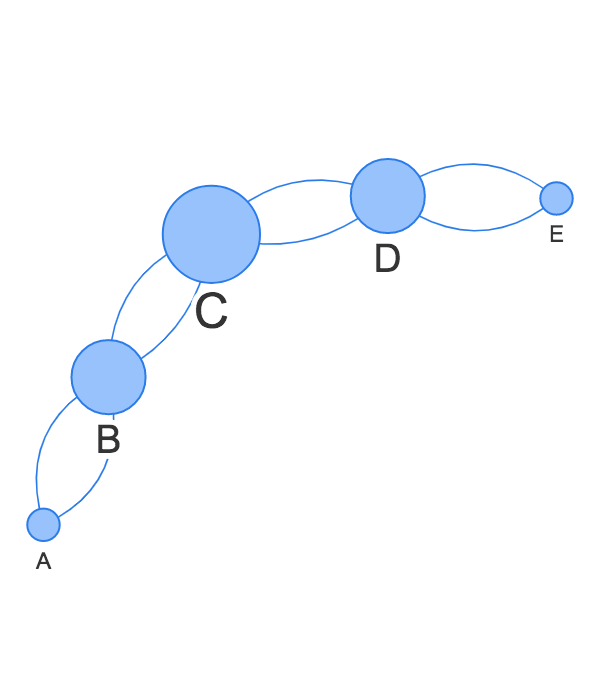

In [10]:
render_image(image_src)